# SeqVAE 評価

In [2]:
import sys
from pathlib import Path
from tqdm import tqdm

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import compare_ssim
from skimage.measure import compare_psnr

import chainer
import chainer.functions as F

sys.path.append('../experiments/SeqVAE/')
from net import SeqVAE
%matplotlib inline

In [3]:
FILE_PATH = Path('.').resolve()
ROOT_PATH = FILE_PATH.parent
RESULT_PATH = ROOT_PATH.joinpath('results/SeqVAE')
MODEL_PATH = ROOT_PATH.joinpath('models/SeqVAE')
print(FILE_PATH)
print(ROOT_PATH)
print(RESULT_PATH)
print(MODEL_PATH)

/home/shimo/CMULAB/Spatio-Temporal-SR/Notebooks
/home/shimo/CMULAB/Spatio-Temporal-SR
/home/shimo/CMULAB/Spatio-Temporal-SR/results/SeqVAE
/home/shimo/CMULAB/Spatio-Temporal-SR/models/SeqVAE


## 1. moving mnist

In [4]:
test_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_test.npy')) \
              .reshape(-1, 20, 1, 64, 64).astype(np.float32) / 255.0
train_data = np.load(ROOT_PATH.joinpath('datasets/moving_mnist_train.npy')) \
               .reshape(-1, 20, 1, 64, 64).astype(np.float32) / 255.0
print(test_data.shape, test_data.dtype, train_data.max())
print(train_data.shape, train_data.dtype, train_data.max())

(1000, 20, 1, 64, 64) float32 1.0
(9000, 20, 1, 64, 64) float32 1.0


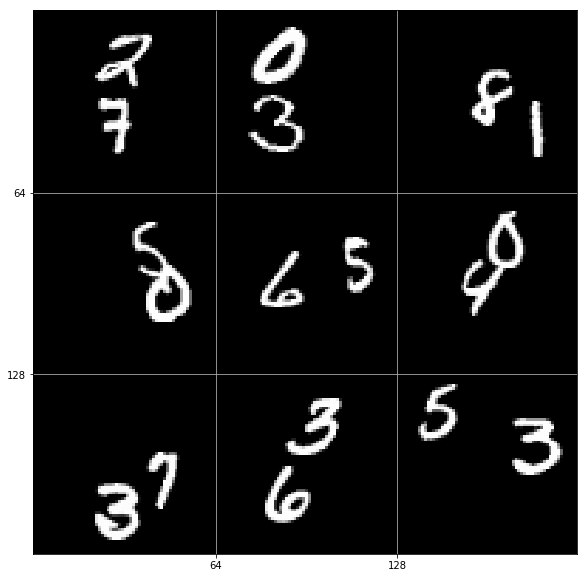

In [13]:
x = test_data[:9, 0]

x = np.clip(x*255, 0, 255).astype(np.uint8) \
    .reshape(3,3,64,64).transpose(0,2,1,3).reshape(64*3,64*3)

plt.figure(figsize=(10, 10))
plt.grid(True)
plt.xticks(np.arange(64, 64 * 3, 64))
plt.yticks(np.arange(64, 64 * 3, 64))
plt.imshow(x, cmap='gray')
plt.imsave('./images/mmnist_gt_noframe.png', x, cmap='gray')

plt.savefig('./images/mmnist_gt.png')
plt.show()

In [6]:
model = SeqVAE(64, 1, 100, 8)

chainer.serializers.load_npz(MODEL_PATH.joinpath('mmnist_test',
    'SeqVAE_latent100_ch8_coef11.0_coef10.01.npz'), model)

### 1.0 再構築

In [7]:
x = test_data[:9, 0]
print(x.shape)

with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_rec = model(x).array \
                .reshape(-1, 64, 64)

x_rec = np.clip(np.array(x_rec)*255, 0, 255).astype(np.uint8)

(9, 1, 64, 64)


(9, 64, 64) 254 uint8


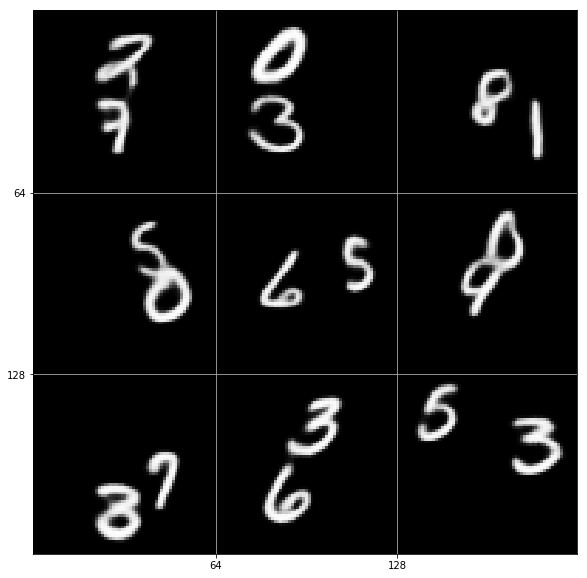

In [8]:
print(x_rec.shape, x_rec.max(), x_rec.dtype)

plt.figure(figsize=(10, 10))
plt.grid(True)
plt.xticks(np.arange(64, 64 * 3, 64))
plt.yticks(np.arange(64, 64 * 3, 64))
plt.imshow(x_rec.reshape(3,3,64,64).transpose(0,2,1,3).reshape(64*3, 64*3), cmap='gray')
plt.savefig('./images/mmnist_seqvae.png')
plt.show()

### 1.1 psnr, ssim評価

In [86]:
# test

psnrs = []
ssims = []

for x_true in tqdm(test_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = model(x_true).array
    x_true = np.clip(x_true*255, 0, 255).astype(np.uint8).reshape(64,64)
    x_rec = np.clip(x_rec*255, 0, 255).astype(np.uint8).reshape(64,64)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

100%|██████████| 1000/1000 [00:11<00:00, 90.61it/s]

psnr mean 20.222199963961522
ssim mean 0.8960087242530713


In [87]:
# train

psnrs = []
ssims = []

for x_true in tqdm(train_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = model(x_true).array
    x_true = np.clip(x_true*255, 0, 255).astype(np.uint8).reshape(64,64)
    x_rec = np.clip(x_rec*255, 0, 255).astype(np.uint8).reshape(64,64)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

100%|██████████| 9000/9000 [01:43<00:00, 90.55it/s]

psnr mean 20.288893856785155
ssim mean 0.8965819064189248


#### 1.1.1 再構築の誤差

### 1.2 連続性評価

In [9]:
num_if = 10
seqs = []
for i in tqdm(range(10)):
    xs = test_data[i, [0, 1, 2],:]
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        zs = model.encode(xs)[0].array
        z_01 = zs[0] + np.kron(np.linspace(0, 1, num_if).astype(np.float32).reshape(num_if, 1, 1),
                                (zs[1] - zs[0]))
        z_12 = zs[1] + np.kron(np.linspace(0, 1, num_if).astype(np.float32).reshape(num_if, 1, 1),
                                (zs[2] - zs[1]))
        x_seq01 = model.decode(z_01.reshape(-1, 100)).array
        x_seq12 = model.decode(z_12.reshape(-1, 100)).array
    x_seq = np.concatenate((x_seq01, x_seq12[1:]), axis=0) \
                .reshape(-1, 64, 64).transpose(1, 0, 2).reshape(64, -1)

    seqs.append(x_seq)

seqs = np.array(seqs)

100%|██████████| 10/10 [00:00<00:00, 11.51it/s]


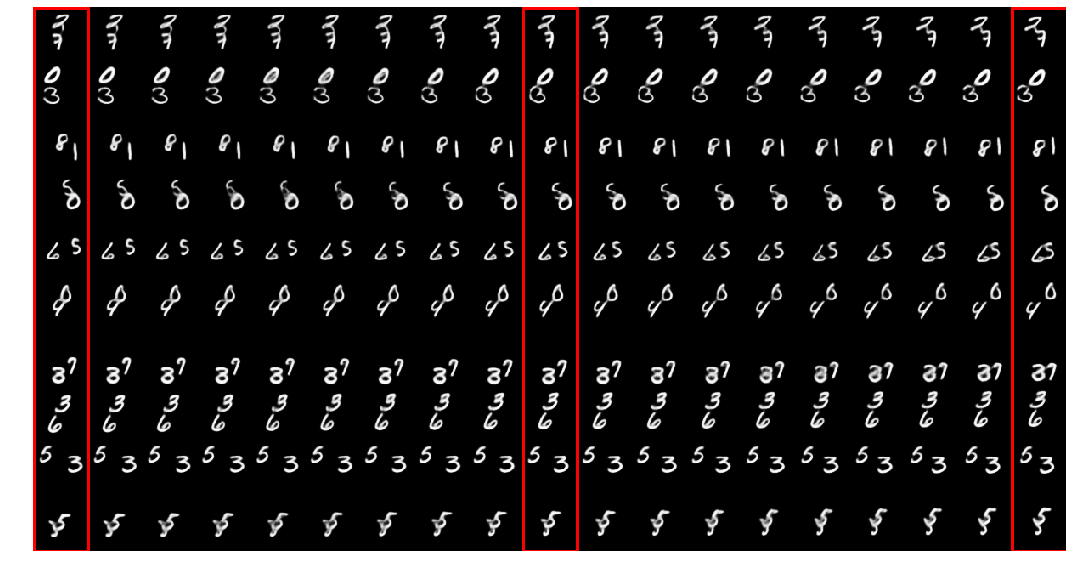

In [11]:
seqs_u = np.clip(seqs*255, 0, 255).reshape(640, -1).astype(np.uint8)

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.xticks(np.arange(64, 64 * 19, 64))
plt.yticks(np.arange(64, 64 * 10, 64))
plt.imshow(seqs_u, cmap='gray')
plt.imsave('./images/sequence_seqvae_mmnist_noframe.png', seqs_u, cmap='gray')
plt.axis('off')
rect = patches.Rectangle(xy=(0,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*9,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*18,0), width=64, height=640, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
plt.savefig('./images/sequence_seqvae_mmnist.png')
plt.show()

## COIL

In [16]:
np.load('../datasets/sequence_coil_100_test.npy').shape

(10, 72, 64, 64, 3)

In [17]:
test_data = np.load(ROOT_PATH.joinpath('datasets/sequence_coil_100_test.npy')) \
    .reshape(-1, 72, 64, 64, 3).transpose(0, 1, 4, 2, 3).astype(np.float32) / 255.0
train_data = np.load(ROOT_PATH.joinpath('datasets/sequence_coil_100_train.npy')) \
    .reshape(-1, 72, 64, 64, 3).transpose(0, 1, 4, 2, 3).astype(np.float32) / 255.0
print(test_data.shape, test_data.dtype, train_data.max())
print(train_data.shape, train_data.dtype, train_data.max())

(10, 72, 3, 64, 64) float32 1.0
(90, 72, 3, 64, 64) float32 1.0


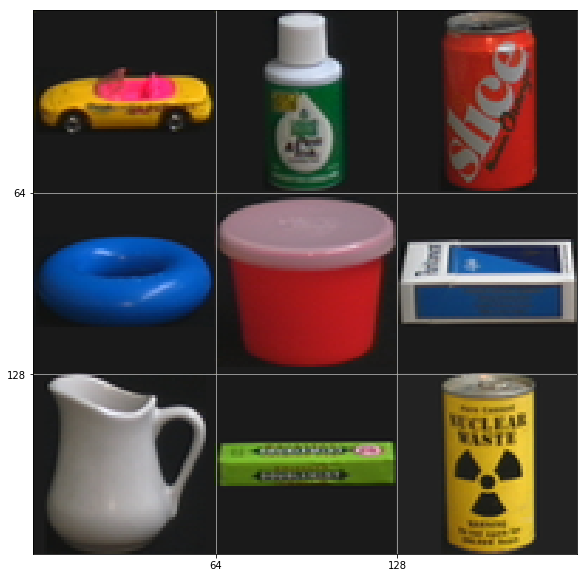

In [19]:
x = test_data[:9, 0]

x = np.clip(x*255, 0, 255).astype(np.uint8) \
    .reshape(3,3,3,64,64).transpose(0,3,1,4,2).reshape(64*3,64*3,3)

plt.figure(figsize=(10, 10))
plt.grid(True)
plt.xticks(np.arange(64, 64 * 3, 64))
plt.yticks(np.arange(64, 64 * 3, 64))
plt.imshow(x)
plt.savefig('./images/coil_gt.png')
plt.show()